# Permutation test session

In [1]:
import pandas as pd
import numpy as np
import matplotlib as plt
import itertools
from scipy import stats
from scipy.special import comb

In [2]:
def get_t_statistic(data, ind, var):
    d = data.loc[data.index.isin(ind), var].values
    p = data.loc[~data.index.isin(ind), var].values
    return stats.ttest_ind(d,p)[0]

In [3]:
def get_mean_difference(data, ind, var):
    d = data.loc[data.index.isin(ind), var].values
    p = data.loc[~data.index.isin(ind), var].values
    return np.mean(d) - np.mean(p)

# Outline

- [Experimental situation](#1)
- [Intuitive idea](#2)
- [Permutation test in action: a t-test example](#3)
- [Permutation test in action: another statistic](#4)
- [Montecarlo or approximated permutation test](#5)
- [Permutation test and AB testing](#6)
- [(Brief) Introduction to Bootstrap](#7)

<a name='1'></a>
## Experimental situation

We are part of a team in charge of analysing a randomised study which aim is to check if there exists a relationship between a drug (*D*) and the level of ethinyl estradiol (*EE*), which is a estrogen medication.

To carry out the study, a (random) sample of women is obtained. All of them are taken contraceptive with ethinyl estradiol (*EE*). We want to study the influence of the drug *D* on the levels of *EE*. Such a level is measured by the variable *area under the curve* (*AUC*). That is: *EEAUC*.

In total, there are 16 women. 8 receive the drug *D* and 8 receives a placebus *P*.

In [4]:
data = pd.read_csv('./data/women.csv')
print(data.head())

  treat   EEAUC
0     P  2623.0
1     D  3756.2
2     P  2227.7
3     D  2986.9
4     D  3858.2


In [5]:
print(data.treat.value_counts())

D    8
P    8
Name: treat, dtype: int64


In [6]:
data.groupby('treat')['EEAUC'].mean()

treat
D    3649.6750
P    2843.3375
Name: EEAUC, dtype: float64

<AxesSubplot:title={'center':'EEAUC'}, xlabel='[treat]'>

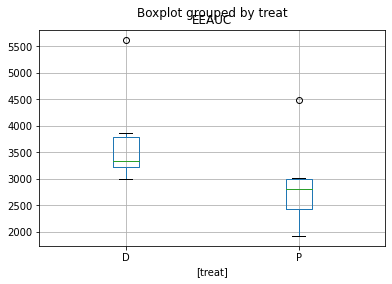

In [7]:
data.boxplot(by='treat')

We could proceed with *t-test* to check if there exists a difference between both populations (*p-value*, bla bla bla). 

In [8]:
d = data.loc[data.treat == 'D']['EEAUC'].values
p = data.loc[data.treat == 'P']['EEAUC'].values
t_estimator, p_value = stats.ttest_ind(d,p)
print(f'The value of the estimator is {t_estimator}. The p-value is {p_value}')

The value of the estimator is 1.975623331867878. The p-value is 0.06824878677237675


An alternative way of analysing this data is by means of **permutation test**.

<a name='2'></a>
# Intuitive idea

If the two samples that we are comparing (*D* and *P*) have the variable *AUC* equal, belonging to *D* or *P* is simply a label and it has no relation with the fact that AUC is large or small systematically. With this statement we are **establishing $H_0$**.

As a consequence, it is equally probable to observe the previous sample and any permutation of the sample in which the values of *AUC* belong to *D* or *P* in another way.

In [9]:
new_data = data.copy()
new_data['treat'] = np.random.permutation(new_data.treat)
print('Original data:\n', data.head(), '\n\n Permuation:\n', new_data.head())

Original data:
   treat   EEAUC
0     P  2623.0
1     D  3756.2
2     P  2227.7
3     D  2986.9
4     D  3858.2 

 Permuation:
   treat   EEAUC
0     P  2623.0
1     D  3756.2
2     P  2227.7
3     P  2986.9
4     P  3858.2


A method of pure hard strength consists in:

- Calculating the statistic on the original data
- Numbering all possible permutatuins of the data
- Computing a proper statistic for each permutation 
- Counting how many times this value is more extrem than the original one

In our case, there are *16!* permutations. This is not feaseable at all!!!!. However, since some of the *16!* perms are repeated, we could avoid some of them (Why??). In the end, we need:

$$\frac{16!}{8!\cdot8!} = 12870$$

<a name='3'></a>
# Permutation test in action: a t-test example

The way to proceed with the permutation test is the following one:

1. Calculation of statistic for the original data
2. List of all possible combinations
3. Calculation of statistic for each one of these indexes resortings
4. Finally, *p-value*: proportion of times that the statistic computed from permutations is equal or more extrem than the one compuded from the original data

In [10]:
# 1. t-statistic for the original data
d = data.loc[data.treat == 'D']['EEAUC'].values
p = data.loc[data.treat == 'P']['EEAUC'].values
t_orig, _ = stats.ttest_ind(d,p)
print(f'The t-statistic for the original data is {t_orig}')

The t-statistic for the original data is 1.975623331867878


In [11]:
# 2. List of all possible combinations
all_combinations_d = itertools.combinations(range(len(data.index)), sum(data.treat == 'D'))

In [12]:
# What does itertools.combinations do?
all_comb = itertools.combinations(range(5), 3)
for comb in all_comb:
    print(comb)

(0, 1, 2)
(0, 1, 3)
(0, 1, 4)
(0, 2, 3)
(0, 2, 4)
(0, 3, 4)
(1, 2, 3)
(1, 2, 4)
(1, 3, 4)
(2, 3, 4)


In [13]:
# 3. Calculation of statistic for each one of these indexes resortings
result = [get_t_statistic(data=data, ind=sample, var='EEAUC') for sample in all_combinations_d]

In [14]:
print(f'Total number of permutations: {len(result)}')

Total number of permutations: 12870


(array([  37.,  240.,  936., 2119., 3103., 3103., 2119.,  936.,  240.,
          37.]),
 array([-3.53283713, -2.82626971, -2.11970228, -1.41313485, -0.70656743,
         0.        ,  0.70656743,  1.41313485,  2.11970228,  2.82626971,
         3.53283713]),
 <BarContainer object of 10 artists>)

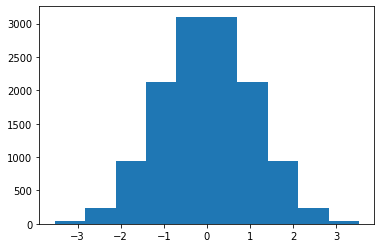

In [15]:
plt.pyplot.hist(result)

In [16]:
# 4. Finally, p-value
sum(result>=t_orig)/len(result)

0.031235431235431235

Why is this *p-value* different from the *p-value* of the *t-test*???

<details><summary>CLICK ME</summary>
<p>
The p-value we have just obtained refers to unilateral test in which we consider the alternative hypothesis:
    
$$H_1 : D > P$$

In order to perform the bilateral test with $H_1 : D \ne P$, the most appropriate statistic is the absolute value of t-Student because if both negative and positive differences are far away from zero, there are evidences against the null hypothesis.
    
</p>
</details>

In [ ]:
# Place the code here
# # 4.1 Finally, p-value

<a name='4'></a>
# Permutation test in action: another statistic

we have just seen a use case of permutation test. However, we could avoid it because we could use *t-test* to analyse the hypothesis test. 

**What are the benefits of permutation tests?**

One of the advantages of permutation tests is that we can use the statistic that best expresses the type of differences we want to show, and we are not forced to use a statistic which distribution under null hypothesis is mathematically easy to determine and with good statistical prorperties. 

The permutation mechanism allows to ingnore the necessity of good mathematical behavior.
Computation of p-value is easy

In this part we are going to analyse the same data but, instead of using *t-statistic*, we are going to use the following one:

$$diff = mean(d) - mean(p)$$

In [17]:
all_combinations_d = itertools.combinations(range(len(data.index)), sum(data.treat == 'D'))
result = [get_mean_difference(data=data, ind=sample, var='EEAUC') for sample in all_combinations_d]

(array([ 118.,  604., 1328., 2013., 2372., 2372., 2013., 1328.,  604.,
         118.]),
 array([-1185.5875,  -948.47  ,  -711.3525,  -474.235 ,  -237.1175,
            0.    ,   237.1175,   474.235 ,   711.3525,   948.47  ,
         1185.5875]),
 <BarContainer object of 10 artists>)

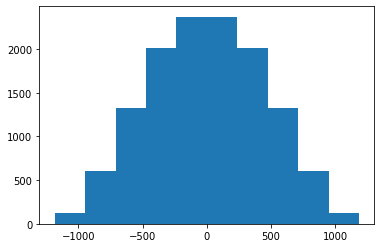

In [18]:
plt.pyplot.hist(result)

In [19]:
index_d = data.loc[data.treat == 'D'].index
mean_original = get_mean_difference(data=data, ind=index_d, var='EEAUC')
print(f'The original statistic is: {mean_original}')

The original statistic is: 806.3375000000001


In [20]:
sum(np.abs(result)>=mean_original)/len(result)

0.06247086247086247

In [21]:
# We can get a CI for the t-statistic:
level = 0.05
ci = np.quantile(result, [level/2, 1-level/2])
print(f'{100*(1-level)}% CI: ({ci[0]}, {ci[1]})')

95.0% CI: (-828.3399999999998, 828.3399999999998)


<a name='4'></a>
# Montecarlo or approximated permutation test

Exact permutation test as the previous one is impossible to be computed for medium or large sample sizes. The most usual solution is doing an aproximated permutation test or Montecarlo test. 

In this approach, a random sample of permutations is simulated, usually very large but smaller than the whole 'population' of possible permutations, which can be huge. Proceeding in this way, a *p-value* estimation is obtained which can be supposed very precise.

<a name='5'></a>
# Permutation test and AB testing
We decide to perform an *AB test* in order to check the performance of our new algorithm (**A group**). For this experiment, the following decisions are taken:
- Split the population randomly with 50% of probability
- Same sample size in both groups (100 visits)

Once the experiment is finished, we take the data and analyse it. We have to decide if the new algorithm has a better performace, which means **having a higher click rate**.

In [22]:
ab_result = pd.read_csv('./data/ab.csv')

In [23]:
ab_result.head(10)

,group,click
0,B,1
1,A,0
2,A,1
3,A,1
4,B,0
5,A,0
6,B,1
7,A,1
8,A,0
9,B,1


In [24]:
ab_result.groupby('group')['click'].mean()

group
A    0.78
B    0.55
Name: click, dtype: float64


We are going to perform a permutation test to analyse if the "labels" are exchangeable. The equivalent parametric hypothesis test would be following one:

$$\left\{
\begin{array}{ll}
      H_0 & \mu_A=\mu_B \\
      H_1 & \mu_A \ne \mu_B \\
\end{array} 
\right. $$

Instef uf using traditional hypothesis test (*binomial test* is this case),  we are going to use permutation test. So, we are testing whether the labels are exchangeable or not. As the statistic we will use the mean difference. Notice that if we wanted to perform the exact permutation test we would need a lot of permutatitions:

$$\frac{200!}{100!\cdot100!}.$$

We are going to use *Montecarlo permutation test* with 9999 permutations. When using this approximation, an unbiased estimator of *p-value* is the following one:

$$\frac{\text{simulations} >= \text{original statistic} \bf{+1}}{\text{total_perms} \bf{+1}}$$

In [25]:
# First, we calculate the statistic for the original sample
ind = ab_result.loc[ab_result.group == 'A'].index
orig_stat = get_mean_difference(data=ab_result, ind=ind, var='click')
print(f'The original statistic is: {orig_stat}')

The original statistic is: 0.22999999999999998


In [26]:
# Generate permutations
total_perms = 9999
sample_size = len(ab_result)
len_a = sum(ab_result.group == 'A')
ind_list = [np.random.choice(sample_size, len_a) for i in range(total_perms)]
result = [get_mean_difference(data=ab_result, ind=ind, var='click') for ind in ind_list]
print(f'Total permutations: {len(result)}')

Total permutations: 9999


In [27]:
p_value = (sum(np.abs(result) >=orig_stat) +1)/(len(result)+1)
print(f'p-value: {p_value}')

p-value: 0.0011


Given such a *p-value*. Do you think you could have used result to estimate a CI for the the t-test?

(array([   9.,   82.,  548., 1620., 3088., 2677., 1480.,  434.,   57.,
           4.]),
 array([-0.27175368, -0.21673623, -0.16171878, -0.10670133, -0.05168387,
         0.00333358,  0.05835103,  0.11336848,  0.16838593,  0.22340338,
         0.27842084]),
 <BarContainer object of 10 artists>)

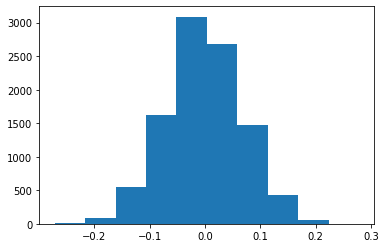

In [28]:
plt.pyplot.hist(result)

In [29]:
# We can get a CI for the t-statistic:
level = 0.05
ci = np.quantile(result, [level/2, 1-level/2])
print(f'{100*(1-level)}% CI: ({ci[0]}, {ci[1]})')

95.0% CI: (-0.13320463320463327, 0.1328125)


<a name='7'></a>
## (Brief) Introduction to Bootstrap

Bootstrap method is a technique that provides a general methodology useful to determine the sample distribution of a statistic. Like permutation test, is a resampling method where **replacement** is needed.

In [30]:
n_boots = 1000
a_values = ab_result.loc[ab_result.group == 'A', 'click'].values
b_values = ab_result.loc[ab_result.group == 'B', 'click'].values
diff_mean = []
for i in range(n_boots):
    ind_a = np.random.choice(len(a_values), len(a_values), replace=True)
    ind_b = np.random.choice(len(b_values), len(b_values), replace=True)
    a_mean = np.mean(a_values[ind_a])
    b_mean = np.mean(b_values[ind_b])
    diff_mean.append(a_mean-b_mean)

(array([  2.,  11.,  59., 122., 268., 274., 164.,  77.,  21.,   2.]),
 array([-0.01 ,  0.037,  0.084,  0.131,  0.178,  0.225,  0.272,  0.319,
         0.366,  0.413,  0.46 ]),
 <BarContainer object of 10 artists>)

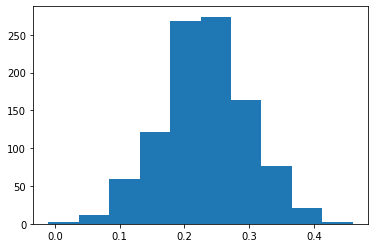

In [31]:
plt.pyplot.hist(diff_mean)

In [32]:
# We can get a CI for the means difference:
level = 0.05
ci = np.quantile(diff_mean, [level/2, 1-level/2])
print(f'{100*(1-level)}% CI: ({ci[0]}, {ci[1]})')

95.0% CI: (0.10999999999999999, 0.36000000000000004)
